<a href="https://colab.research.google.com/github/ciphenseadmin/partial-face-recognition/blob/master/SubsetLfwCropped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First of all, You will need to install a face detector library. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import os
from google.colab.patches import cv2_imshow
import dlib


Using TensorFlow backend.


In [0]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("/content/drive/My Drive/SubsetLfw"))

# Any results you write to the current directory are saved as output.

['val', 'train']


See a sample image

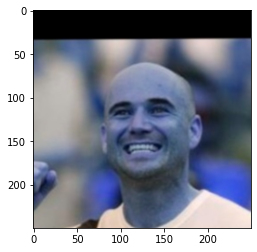

(250, 250, 3)


In [0]:
img = cv2.imread('/content/drive/My Drive/SubsetLfw/train/Andre_Agassi/Andre_Agassi_0029.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(img.shape)

In [0]:
faceDetector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/My Drive/shape_predictor_68_face_landmarks.dat')


In [0]:
# detect faces in image
def extract_face(img, subdir, filename):
  img= cv2.imread(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  faces = faceDetector(img, 1)
  # print(faces)

  # Now process each face we found
  for k, face in enumerate(faces):
    # cv2_imshow(img)
    img = img[face.top():face.bottom(), face.left():face.right()]
    # cv2_imshow(img)
    if isinstance(img.size, int) and img.size!=0:
      cropped_img= cv2.resize(img, (160,160))
      # Find facial landmarks for each detected face
      face= dlib.rectangle(0,0,160,160)
      shape = predictor(cropped_img, face)
      # convert landmarks from Dlib's format to list of (x, y) points
      landmarks = [(p.x, p.y) for p in shape.parts()]
      # for (x,y) in landmarks:
          # cv2.circle(cropped_img,(x,y), 1, (255, 0, 0), -1)

      # cv2_imshow(cropped_img)
      pts2 = np.array([[0,0],[0,landmarks[1][1]], [landmarks[1][0], landmarks[1][1]], [landmarks[29][0], landmarks[29][1]],[landmarks[15][0], landmarks[15][1]],[160,landmarks[15][1]], [160,0] ], np.int32)
      pts2 = pts2.reshape((-1,1,2))

      mask = np.zeros(cropped_img.shape[0:2], dtype=np.uint8)
      #smooth region
      cv2.drawContours(mask, [pts2], -1, (255, 255, 255), -1, cv2.LINE_AA)
      # cv2_imshow(mask)
      res = cv2.bitwise_and(cropped_img,cropped_img,mask = mask)
      # cv2_imshow(res)
      rect = cv2.boundingRect(pts2) # returns (x,y,w,h) of the rect
      cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]

      ## crate the white background of the same size of original image
      wbg = np.ones_like(cropped_img, np.uint8)*255
      # cv2_imshow(wbg)
      cv2.bitwise_not(wbg,wbg, mask=mask)
      # overlap the resulted cropped image on the white background
      dst = wbg+res
      dst2 = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
      # cv2_imshow(dst2)
      """
      CHANGE TEST/TRAIN IN MAIN_PATH DEPENDING UPON WHICH ONE YOU'RE SAVING. RUN THIS CELL AGAIN
      """
      main_path= "/content/drive/My Drive/SubsetLfwCropped/test"
      joined_path= os.path.join(main_path, subdir)
      if not os.path.exists(joined_path):
            os.makedirs(joined_path)
      os.chdir(joined_path)
      # print(joined_path)
      # print(filename)
      # print(subdir)
      # image_path= os.path.join(filename, .jpg)
      cv2.imwrite("{}.jpg".format(str(filename)), dst2)
      
      # print(save)
      # print(dst.shape)
      # cv2_imshow(dst)
      # cv2_imshow(dst2)
      dst_array = np.asarray(dst2)
      # plt.imshow(dst_array)
      # plt.show()
      # print(dst_array)
      return dst_array
    else:
      return "None"

In [0]:
!ls

drive  sample_data


In [0]:
img= cv2.imread("/content/drive/My Drive/SubsetLfw/train/Andre_Agassi/Andre_Agassi_0028.jpg")
extract_face(img, "Andre_Agassi2", "Andre_Agassi_0028")
# filename= "blah2"
# cv2.imwrite("{}.jpg".format(filename), img)

The extract_face function load a image file and return the extracted face in 160 * 160 pixels shape as needed for trained FaceNet model
Try the extract_face() on the sample image. Works nicely

In [0]:
filename= "/content/drive/My Drive/SubsetLfw/train/Andre_Agassi/Andre_Agassi_0029.jpg"
extract_face(filename)

Apply extract_face() for all faces in the dataset

In [0]:
def load_face(dir, subdir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        # print(filename)
        path = dir + filename
        face = extract_face(path, subdir, filename)
        if isinstance(face, np.ndarray):
            faces.append(face)  
            # cv2_imshow(face)
        else:
          continue
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path, subdir)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('/content/drive/My Drive/SubsetLfw/train/')
print(trainX.shape, trainy.shape)       

loaded 6 sample for class: Zhu_Rongji
loaded 4 sample for class: Yasser_Arafat
loaded 9 sample for class: Yoriko_Kawaguchi
loaded 22 sample for class: Vicente_Fox
loaded 6 sample for class: Vaclav_Havel
loaded 11 sample for class: Venus_Williams
loaded 34 sample for class: Vladimir_Putin
loaded 5 sample for class: Tung_Chee-hwa
loaded 16 sample for class: Winona_Ryder
loaded 7 sample for class: Walter_Mondale
loaded 9 sample for class: Wen_Jiabao
loaded 11 sample for class: Trent_Lott
loaded 5 sample for class: Yao_Ming
loaded 7 sample for class: Tommy_Thompson
loaded 11 sample for class: Tommy_Franks
loaded 7 sample for class: Tom_Cruise
loaded 6 sample for class: Thomas_OBrien
loaded 100 sample for class: Tony_Blair
loaded 16 sample for class: Tiger_Woods
loaded 17 sample for class: Tom_Daschle
loaded 7 sample for class: Tom_Hanks
loaded 13 sample for class: Tim_Henman
loaded 23 sample for class: Tom_Ridge
loaded 5 sample for class: Sheryl_Crow
loaded 6 sample for class: Sylvester_St

In [0]:
# load test dataset
testX, testy = load_dataset('/content/drive/My Drive/SubsetLfw/val/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('SubsetLfw.npz', trainX, trainy, testX, testy)

loaded 3 sample for class: Zhu_Rongji
loaded 3 sample for class: Walter_Mondale
loaded 10 sample for class: Vicente_Fox
loaded 4 sample for class: Wen_Jiabao
loaded 6 sample for class: Venus_Williams
loaded 3 sample for class: Yao_Ming
loaded 5 sample for class: Yoriko_Kawaguchi
loaded 15 sample for class: Vladimir_Putin
loaded 3 sample for class: Yasser_Arafat
loaded 8 sample for class: Winona_Ryder
loaded 3 sample for class: Vaclav_Havel
loaded 3 sample for class: Tom_Cruise
loaded 5 sample for class: Tommy_Franks
loaded 3 sample for class: Tung_Chee-hwa
loaded 10 sample for class: Tom_Ridge
loaded 3 sample for class: Tommy_Thompson
loaded 5 sample for class: Trent_Lott
loaded 8 sample for class: Tom_Daschle
loaded 3 sample for class: Tom_Hanks
loaded 44 sample for class: Tony_Blair
loaded 4 sample for class: Tang_Jiaxuan
loaded 3 sample for class: Sylvester_Stallone
loaded 3 sample for class: Shimon_Peres
loaded 3 sample for class: Sheryl_Crow
loaded 6 sample for class: Tim_Henman
l

In [0]:
# load the face dataset
data = np.load('SubsetLfw.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (3264, 160, 160, 3) (3264,) (1539, 160, 160, 3) (1539,)


In [0]:
# load the facenet model
facenet_model = load_model('/content/drive/My Drive/facenet/keras-facenet/model/facenet_keras.h5')
print('Loaded Model')

Loaded Model


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Next step is standardizing the faces and extracting a embedding vector using the model

In [0]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)
# print(emdTrainX)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)
# print(emdTestX)

# save arrays to one file in compressed format
np.savez_compressed('SubsetLfw.npz', emdTrainX, trainy, emdTestX, testy)

(3264, 128)
(1539, 128)


In [0]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=3264, test=1539
Accuracy: train=81.801, test=71.605


Randomly select a face from test set for prediction. Calculate confidence

Predicted: 
['Abdullah_Gul' 'Adrien_Brody' 'Al_Gore' 'Alejandro_Toledo'] 
[0.1714359  0.27812438 0.22098575 1.67720011 0.15388581 1.2656748
 0.13492829 0.21036024 0.26549709 0.30043972 0.1694032  0.11078519
 0.22086654 0.3393828  0.20593945 0.46221652 0.4168095  0.2485539
 0.42489041 0.28499765 0.50973628 0.45293481 0.48876552 0.34992921
 0.68743688 0.11816859 0.29937764 0.22794294 0.15466973 0.11190356
 0.10161891 0.35261082 0.55025588 0.08865692 0.63867053 0.08144356
 0.79306676 0.27201167 0.35032905 0.21574571 2.45989468 0.58233408
 2.04996637 0.23972198 0.44886708 0.34612697 0.43893995 0.27512128
 0.79334461 0.39284983 0.57100874 0.24165298 0.10213388 0.19409385
 0.43744821 1.11907148 0.5226346  0.22056257 0.90108783 1.12686201
 0.29393818 0.13396388 0.11580049 0.58429341 0.14688007 0.16582497
 1.31273922 0.52480434 0.28763323 2.19789445 0.23730921 0.20209291
 0.48918167 0.63270655 0.14703715 0.29930195 0.36008609 0.35633431
 0.50593443 0.62206095 0.70747095 0.3121529  0.23093864 0

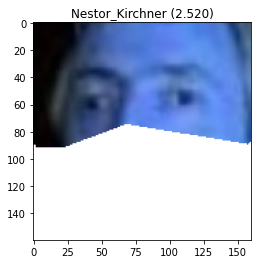

In [0]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()